**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# A Diffusion Drift-Flux Model for Two-Phase Mixture Flow
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

**Student(s):**  Nik Kemper and Jack Kennedy<br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
  + [Weak Form of Problem Statement](#weakform)
  + [MOOSE Kernels](#kernels)
  + [Setup](#setup)
  + [Tests](#tests)
   - [Solo mixture](#solomixture)
   - [Solo vapor](#solovapor)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
 + [Tests](#tests)
   - [Fuel](#fuel)

## [Introduction](#toc)<a id="intro"></a>

- The volume-average method is used for deriving a two-phase mixture balance equation for the motion of two fluid phases. The balance equation for the vapor phase is closed by a diffusion drift-flux constitutive equation. Boundary conditions for a developing fluid flow are used in cylindrical coordinates. This model is a prototype of a mixture theory for two-phase fluid flow in various equipments for example, steam generation from liquid feed water.

- Text... 

## [Problem Statement](#toc)<a id="problem"></a>

Solve the convective-diffusive model problem for a two-phase, 1-D mixture flow with phase change in a pipe. Compute the mixture velocity $v:[a,b]\subset\Reals\rightarrow\Reals$ and vapor fraction $\alpha:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 \text{d}_z\bigl(\rho\,v\bigr) &= 0 \quad \forall \quad z\in [a,b] \\
 \text{d}_z\bigl(\alpha\rho_\text{v}\,v\bigr) -\text{d}_z\Bigl(\alpha\,w_\ell\,\rho\,D\,\text{d}_z w_\text{v}\Bigr) - S_\text{v} & = 0 \quad \forall \quad z\in [a,b] \\
 v(a) &= v_0 \\
 \alpha(a) &= 0, \\
 -\rho\,D \,\text{d}_z w_\text{v}(b) &= 0,
\end{align*}
where $v$ is the velocity of the mixture, $\alpha$ is the vapor fraction, $w_\text{v} = \frac{\rho_\text{v}}{\alpha\rho_\text{v} + (1-\alpha)\rho_\ell}$ is the mass fraction of the vapor (a similar definition is used for the liquid), $\rho_\ell$ is the mass density of the liquid, $\rho_\text{v}$ is the mass density of the vapor, and $-\rho\,D \,\text{d}_z w_\text{v}$ is a diffusion constitutive model of the drift-flux of the vapor, that is: $\rho_\text{v}\,v_\text{d}$, ($v_\text{d}$ is the drift velocity). The vapor source term, $S_\text{v}$ accounts for the mass transfered from the liquid phase into the vapor phase due to vaporization phase change. The inflow port of the pipe is located at $z=a$ where the vapor fraction and mixture velocity are known. The outflow port of the pipe is located at $z=b$ where the diffusive drift flux is zero.

The equations conserve the total mass of the two phase flow system in the $[a,b]$ domain. The model is non-linear in the unknown variables.

In [3]:
'''Domain'''

def show_domain():
    import scipy.constants as unit
    unit.meter = 0.10
    unit.mm = unit.milli*unit.meter
    
    pipe_length = 1*unit.meter
    pipe_id = 3/4*unit.inch
    pipe_wall = 20*unit.mm
    pipe_od = pipe_id + 2*pipe_wall
    
    import pyvista as pv
    pv.set_plot_theme('paraview')
     
    radius_i = pipe_id/2
    radius_o = pipe_od/2
    fluid = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length, radius=radius_i)
    tmp1 = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length, radius=radius_o)
    tmp1 = tmp1.triangulate()
    tmp2 = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=pipe_length*1.1, radius=radius_i)
    tmp2 = tmp2.triangulate()
    tmp2.flip_normals()
    pipe = tmp1.boolean_cut(tmp2)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 

    plo.subplot(0,0)
    plo.add_mesh(fluid, color='orange', opacity=1,)
    plo.add_mesh(pipe, color='black', opacity=.99)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Z')
    cpos = plo.show(window_size=[800, 600])

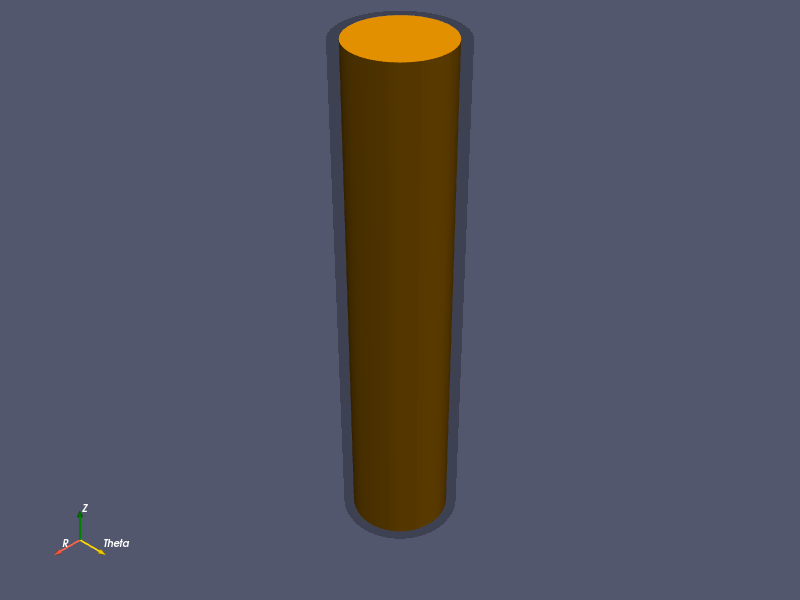

In [4]:
show_domain()

- Text... 

- Text... 

## [Objectives](#toc)<a id="obj"></a>

- Text...

- Text...

## [Approach](#toc)<a id="app"></a>

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#problem) is as follows. Find $v \in H^1\!\bigl([a,b]\bigr)$ and $\alpha \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b \bigl(\Delta\rho\,\alpha'\,v + \rho\, v'\bigr)\, \theta\, dz &= 0 \quad \forall \quad \theta \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
    \int\limits_a^b \rho_\text{v}\,(\alpha'\,v + \alpha\,v')\,\theta\,dz 
  - \int\limits_a^b \alpha\,w_\ell\,w_\text{v}\,\Delta\rho\,D\,\alpha' \theta\,dz 
  - \int\limits_a^b S_\text{v}\,\theta\,dz &= 0 
  \quad \forall \quad \theta \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces.
 
The finite element implementation of this weak form is carried out within the multiphysics object oriented simulation environment, MOOSE, framework.

### [MOOSE Kernels](#toc)<a id="kernels"></a>

The following MOOSE kernels were implemented to solve the [weak form](#weakform):
1. Mixture mass balance term: $\bigl(\Delta\rho\,\alpha'\,v + \rho\, v', \theta\bigr)$ 
 + [interface](./include/kernels/MixtureMassBalDivergence.h) and [implementation](./src/kernels/MixtureMassBalDivergence.C).
1. Vapor convection term: $\bigl(\rho_\text{v}\,(\alpha'\,v + \alpha\,v'),\theta\bigr)$ 
 + [interface](./include/kernels/VaporConvection.h) and [implementation](./src/kernels/VaporConvection.C).
1. Vapor drift-flux diffusion term: $-\bigl(\alpha\,w_\ell\,w_\text{v}\,\Delta\rho\,D\,\alpha', \theta\bigr)$ 
 + [interface](./include/kernels/VaporDriftFluxDiffusion.h) and [implementation](./src/kernels/VaporDriftFluxDiffusion.C).

### [Setup](#toc)<a id="setup"></a>

In [ ]:
'''Domain'''

x_a = 0
x_b = 1000

x_length = x_b - x_a

In [ ]:
'''Parameters'''

rho_l = 1000
rho_v = 2

In [ ]:
'''Data (boundary conditions)'''

alpha_a = 0
v_a = 1

In [ ]:
'''FEM Solution'''


In [ ]:
!./steamer-opt -i input.hit

### [Tests](#toc)<a id="tests"></a>

#### [Solo Mixture](#toc)<a id="solomixture"></a>

#### [Solo Vapor](#toc)<a id="solovapor"></a>

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  u1_legend='no u1 legend',
                  u2_legend='no u2 legend',
                  u1_flux_legend='no u1 flux legend',
                  u2_flux_legend='no u2 flux legend'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(15, 6))

    ax1.plot(df['x'], df['mixtureVelocity'],'r*-',label=u1_legend)
    
    ax1.set_xlabel(r'$x$ [m]', fontsize=18)
    ax1.set_ylabel(r'$u_{1,h}(x)$', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    # create a twin x axis to be shared
    ax2 = ax1.twinx()

    ax2.plot(df['x'], df['vaporFraction'],'*-', color='yellow', label=u2_legend)
        
    ax2.set_ylabel(r"$u_{2,h}(x)$", fontsize=16, color='yellow')
    ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
    ax2.legend(loc='center right', fontsize=12)
    #ax2.set_ylim(0,2)
    ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

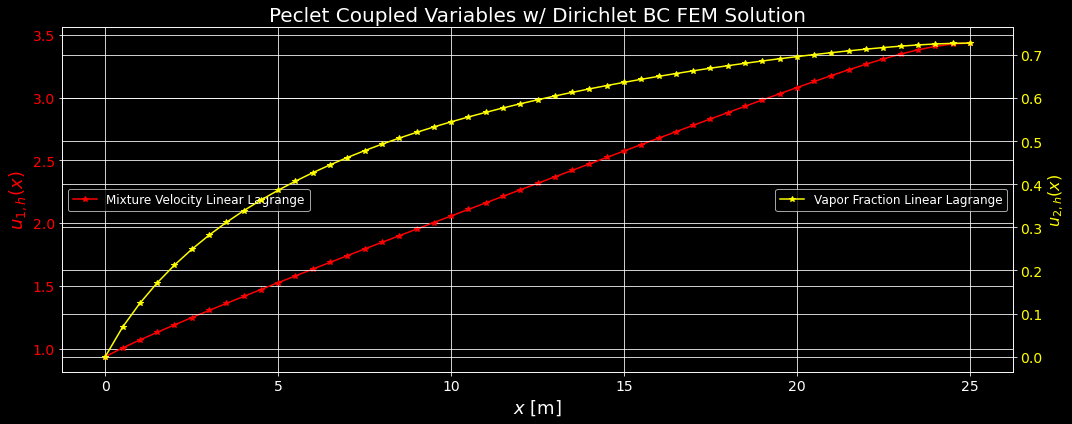

In [2]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'Mixture Velocity Linear Lagrange', u2_legend=r'Vapor Fraction Linear Lagrange')

## <span style="color:red"><b>**Pending:** plot of $\rho$ and $\rho v$</b></span>

In [3]:
df

,id,mixtureVelocity,vaporFraction,x,y,z
0,0.0,0.936700,0.000000,0.0,0,0
1,0.5,1.005481,0.068403,0.5,0,0
2,1.0,1.069053,0.123829,1.0,0,0
3,1.5,1.129971,0.171099,1.5,0,0
4,2.0,1.189152,0.212388,2.0,0,0
5,2.5,1.247078,0.249010,2.5,0,0
6,3.0,1.304043,0.281852,3.0,0,0
7,3.5,1.360244,0.311559,3.5,0,0
8,4.0,1.415820,0.338618,4.0,0,0
9,4.5,1.470875,0.363408,4.5,0,0


## [Results and Analysis](#toc)<a id="ranalysis"></a>

- Text...

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()